# Laboratorio 4

---
Se necesita tener acceso los archivos de google drive para poder usar este código, aqui esta el link de compartir: <br>[Google Drive](https://drive.google.com/drive/folders/1EGaVv-qekeA--pPsToN5DUZC868gv14k?usp=sharing) <br>

--- 
Tabla de contenido


*   Análisis Exploratorio
*   something else



## IMPORTACIONES

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
import re
import io 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk import ngrams
import heapq
import operator
# Load library
from nltk.corpus import stopwords
import os
# You will have to download the set of stop words the first time
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Conexión a Google Drive

In [0]:
!pip install -U -q PyDrive ## you will have install for every colab session
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_list = drive.ListFile({'q': "'1ki9mkoQzQUBeqcUIzud04eAglroryOA7' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Lab4.Backup.ipynb, id: 1w67Smxb16A9R_uDD2mQWrAQH7FF5F5SA
title: conjunctions.txt, id: 1ZbsphfT4RbCzgCaOqEhjZXTzl-eFu3rn
title: prepositions, id: 1GF6NAgVhWjHV1EfRFNBygyMgmYWqGsuUyzy_WFZLl8I
title: prepositions.txt, id: 1zlbTQdhuo2UKDB5V1B_VGfzbCqB5tQpC
title: en_US.twitter.txt, id: 1-TOVJ4t54YYln8-odlTUxH_dSJTqs92s
title: en_US.blogs.txt, id: 1W2rALeghgra2E6h8t9Pu9dqnFHkIX3lg
title: en_US.news.txt, id: 1fUYXYLPfasmPrKfeB2sb3VjEQeay3Afe


### Descarga de los archivos
se consiguen los archivos de google drive, y se van a utilizar los mimos nombres que tenían para llamarlos

In [0]:
enUSNews = drive.CreateFile({'id': '1fUYXYLPfasmPrKfeB2sb3VjEQeay3Afe'})
enUSNews.GetContentFile('en_US.news.txt')


In [0]:
enUSBlogs = drive.CreateFile({'id':'1W2rALeghgra2E6h8t9Pu9dqnFHkIX3lg'})
enUSBlogs.GetContentFile('en_US.blogs.txt')

In [0]:
enUSTwitter = drive.CreateFile({'id':'1-TOVJ4t54YYln8-odlTUxH_dSJTqs92s'})
enUSTwitter.GetContentFile('en_US.twitter.txt')

In [0]:
preposiciones = drive.CreateFile({'id': '1zlbTQdhuo2UKDB5V1B_VGfzbCqB5tQpC'})
preposiciones.GetContentFile('prepositions.txt')

In [0]:
conjunctions = drive.CreateFile({'id': '1ZbsphfT4RbCzgCaOqEhjZXTzl-eFu3rn'})
conjunctions.GetContentFile('conjunctions.txt')

In [0]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

### Cantidad de lineas en los archivos

In [0]:
lineasNews = file_len('en_US.news.txt')
lineasBlogs = file_len('en_US.blogs.txt')
lineasTwitter = file_len('en_US.twitter.txt')

### 5% de esas lineas

In [0]:
def reducirTexto(file, lineas):
  lineas = int(round(lineas * 0.05))
  with open(file) as myfile:
      head = [next(myfile) for x in range(lineas)]
  return head

In [0]:
def mkdir(name, data):
  f = open(name, 'w')
  f.write(str(data))
  f.close()

In [0]:
def openF(filename):
  file = open(filename, 'r')
  return file.read()

In [0]:
reduccion5porciento = reducirTexto('en_US.news.txt', lineasNews)
mkdir("en_US.news.txt", reduccion5porciento)
reduccion5porciento = reducirTexto('en_US.blogs.txt', lineasBlogs)
mkdir("en_US.blogs.txt", reduccion5porciento)
reduccion5porciento = reducirTexto('en_US.twitter.txt', lineasTwitter)
mkdir("en_US.twitter.txt", reduccion5porciento)

## Limpieza de datos (remover @,# y apostrofes)

- Revisar si hay emoticones y quitarlos
- Quitar los artículos, preposiciones y conjunciones (stopwords)
- Quitar números si considera que interferirán en las predicciones.
- Se van a eliminar los emojis, leyendolos por hex y identificando los que estan llamando a emojis
- Quitar los stopwords utilizando NLKT
- Se van a guardar los archivos limpios en:
    * news.txt
    *  blogs.txt
    * twitter.txt

 

In [0]:
def lowerYsub(filename, fileout):
  with open(filename, 'r') as infile, \
       open(fileout, 'w') as outfile:
      data = infile.read()
      data = data.lower()
     
      # Eliminar simbolos
      data = re.sub("@", "", data)
      data = re.sub("#", "", data)
      data = re.sub("&", "", data)
      data = re.sub('\"','', data)      
      data = re.sub("'",'', data)
      data = re.sub(" n, ",'', data)
      data = re.sub(" n ",'', data)
      data = re.sub(" s ",'', data)
      data = re.sub('\,',' ', data)
      data = re.sub('\.',' ', data)
      
      #Eliminar enlaces
      data = re.sub(r'\bhttp\S+', '', data, re.IGNORECASE)
      
      # Eliminar Articulos
      data = data.replace(' a ', ' ')
      data = data.replace(" n ",' ')
      data = data.replace(" s ",' ')
      data = data.replace(" an ", " ")
      data = data.replace(" the ", " ")
      data = data.replace(" and ", " ")
      data = data.replace("\n", " ")
      data = data.replace("\\", " ")
      data = data.replace(".", " ")

      
      outfile.write(data)
      print ("Success")

In [0]:
lowerYsub('en_US.news.txt','news.txt')
lowerYsub('en_US.blogs.txt','blogs.txt')
lowerYsub('en_US.twitter.txt','twitter.txt')

Success
Success
Success


##Quitando Emojis


In [0]:
from codecs import open
try:
    from contextlib import nested  # Python 2
except ImportError:
    from contextlib import ExitStack, contextmanager

    @contextmanager
    def nested(*contexts):
        """
        Reimplementation of nested in python 3.
        """
        with ExitStack() as stack:
            for ctx in contexts:
                stack.enter_context(ctx)
            yield contexts
import re
import sys
from os import path


EMOJI_RE = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251" 
                           "]+", flags=re.UNICODE)

def uopen(*args):
    return open(*args, encoding="UTF-8")

def remove_emoji(in_fname, out_fname):
    with nested(uopen(in_fname), uopen(out_fname, "w")) as (inf, outf):
        for line in inf:
            outf.write(EMOJI_RE.sub(r'', line))

def main():
    in_fname = 'twitter.txt'
    out_fname = 'twitter2.txt'
    in2_fname = 'blogs.txt'
    out2_fname = 'blogs2.txt'
    in3_fname = 'news.txt'
    out3_fname = 'news2.txt'

    remove_emoji(in_fname, out_fname)
    remove_emoji(in2_fname, out2_fname)
    remove_emoji(in3_fname, out3_fname)
    
    
if __name__ == "__main__":
    main()
    

##Quitando Stop Words



In [0]:
import io 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 


def StopWordRemover2000(filename, filewrite):
  file1 = open(filename ,encoding="UTF-8") 
  line = file1.read()# Use this to read file content as a stream: 
  words = line.split() 
  for r in words: 
      if not r in stop_words: 
          appendFile = open(filewrite,'a',encoding="UTF-8") 
          appendFile.write(" "+r) 
          appendFile.close()
  print('Success')
  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
StopWordRemover2000("news2.txt", "news.txt")
StopWordRemover2000("blogs2.txt", "blogs.txt")
StopWordRemover2000("twitter2.txt", "twitter.txt")

Success
Success
Success


## Analisis


## Diccionario de Palabras
Aqui se ba a buscar hacer un contador de cuantas palabras únicas hay y cuantas veces se repite ciertas palabras. Esto es para sacar la frequencia de las palabras y poder sacar graficas del resultado

In [0]:
palabrasNews = {}
palabrasBlog = {}
palabrasTwitter = {}

In [0]:
def word_count(str):
    counts = dict()
    words = str.split()
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts


In [0]:
with open('news.txt', 'r') as infile:
  data = infile.read()
  palabrasNews = word_count(data)
  

In [0]:
with open('blogs.txt', 'r') as infile:
  data = infile.read()
  palabrasBlog = word_count(data)
  

In [0]:
with open('twitter.txt', 'r') as infile:
  data = infile.read()
  palabrasTwitter = word_count(data)

### Ordenar listado
Lo ordenamos para poder hacer busquedas mas rapidas y encontrar las palabras mas comunes. 


In [0]:
sorted(palabrasNews.items(), key=operator.itemgetter(1), reverse=True)

[('n', 100412),
 ('said', 23356),
 ('that', 16177),
 ('is', 13073),
 ('he', 11319),
 ('was', 10618),
 ('it', 10244),
 ('i', 8203),
 ('would', 6994),
 ('are', 6486),
 ('s', 6108),
 ('has', 5792),
 ('have', 5663),
 ('they', 5609),
 ('also', 5550),
 ('will', 5462),
 ('who', 5426),
 ('we', 5312),
 ('be', 4985),
 ('not', 4768),
 ('you', 4556),
 ('--', 4548),
 ('or', 4507),
 ('his', 4408),
 ('this', 4360),
 ('new', 4280),
 ('one', 4206),
 ('could', 4090),
 ('last', 4044),
 ('two', 3984),
 ('—', 3740),
 ('she', 3686),
 ('when', 3655),
 ('had', 3597),
 ('first', 3572),
 ('year', 3462),
 ('were', 3440),
 ('years', 3398),
 ('”', 3312),
 ('state', 3266),
 ('people', 3144),
 ('if', 3108),
 ('can', 3055),
 ('been', 3048),
 ('says', 3010),
 ('000', 2950),
 ('its', 2731),
 ('there', 2661),
 ('time', 2650),
 ('so', 2618),
 ('p', 2564),
 ('which', 2543),
 ('-', 2518),
 ('m', 2514),
 ('more', 2487),
 ('county', 2478),
 ('city', 2476),
 ('their', 2456),
 ('no', 2426),
 ('even', 2418),
 ('school', 2346),


##Histogramas

Se realizan histogramas para un mejor entendimiento


In [0]:
def keyInOrder(listName, number):
  keys = list(sorted(listName, key=listName.__getitem__, reverse=True))
  keys = keys[:number]
  firstFew = {x:listName[x] for x in keys}
  return firstFew

### News

Podemos observar que la palabra que mas se repite en News es n seguida por to y of


In [0]:
keys = keyInOrder(palabrasNews, 20)

Text(0.5,1,'News')

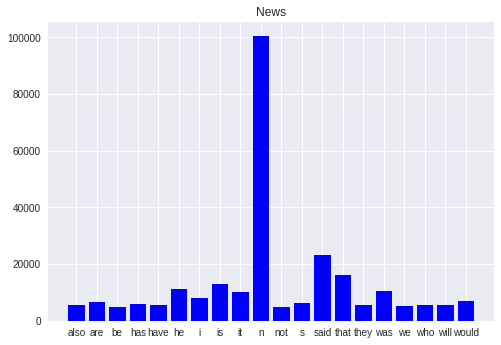

In [0]:
plt.bar(keys.keys(), keys.values(), color='b')
plt.title("News")

### Blogs

Podemos observar que la palabra que mas se repite en Blogs es n

In [0]:
keys = keyInOrder(palabrasBlog, 20)

Text(0.5,1,'Blog')

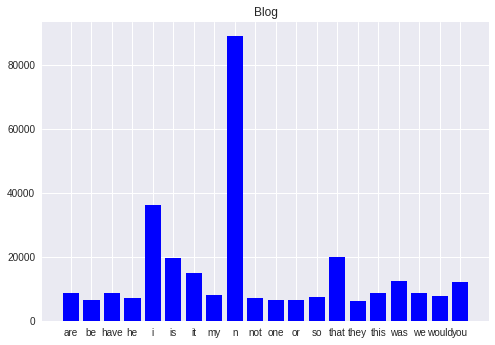

In [0]:
plt.bar(keys.keys(), keys.values(), color='b')
plt.title("Blog")

### Twitter

Podemos observar que la palabra que mas se repite en Twitter es n, seguida por i y to


In [0]:
keys = keyInOrder(palabrasTwitter, 15)

Text(0.5,1,'Twitter')

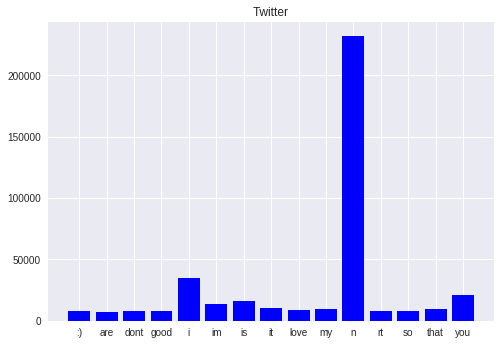

In [0]:
plt.bar(keys.keys(), keys.values(), color='b')
plt.title("Twitter")

##N-Grams

Los N-gramas se generan dividiendo el corpus de cada archivo en tokens, y se acoplan por N componentes.
Por ejemplo se divie en bigrama "n = 2", se acopla por cada 2 palabras.

Para este proceso se utilizara la libreria nltk con el apartado ngrams
###ngrams(corpus.tokens, n)

###Ejemplo:

Corpus : "I really like python, it's pretty awesome."

n = 4

output:

['I', 'really', 'like', 'python,']

['really', 'like', 'python,', "it's"]

['like', 'python,', "it's", 'pretty']

['python,', "it's", 'pretty', 'awesome.']



In [0]:
def Ngram(n, text, printing):
  limiter = 0
  nGram = ngrams(text.split(), n)
  if (printing):
    for grams in nGram:
      if (limiter > 50):
         break
      print (grams)    
      limiter += 1
  return nGram
  

In [0]:
news = openF("news.txt")
blogs = openF("blogs.txt")
twitter = openF("twitter.txt")

In [0]:
biGramNews = Ngram(2, news, True)
triGramNew = Ngram(3, news, True)

('[he', 'wasnt')
('wasnt', 'home')
('home', 'alone')
('alone', 'apparently')
('apparently', 'n')
('n', 'st')
('st', 'louis')
('louis', 'plant')
('plant', 'hadclose')
('hadclose', 'it')
('it', 'would')
('would', 'dieold')
('dieold', 'age')
('age', 'workers')
('workers', 'had')
('had', 'been')
('been', 'making')
('making', 'cars')
('cars', 'thereonsetmass')
('thereonsetmass', 'automotive')
('automotive', 'production1920s')
('production1920s', 'n')
('n', 'wsus')
('wsus', 'plans')
('plans', 'quickly')
('quickly', 'became')
('became', 'hot')
('hot', 'topiclocal')
('topiclocal', 'online')
('online', 'sites')
('sites', 'though')
('though', 'most')
('most', 'people')
('people', 'applauded')
('applauded', 'plansnew')
('plansnew', 'biomedical')
('biomedical', 'center')
('center', 'many')
('many', 'deplored')
('deplored', 'potential')
('potential', 'lossbuilding')
('lossbuilding', 'n')
('n', 'alaimo')
('alaimo', 'groupmount')
('groupmount', 'holly')
('holly', 'was')
('was', 'upcontract')
('upcont

In [0]:
biGramblogs = Ngram(2, blogs, True)
triGramBlogs = Ngram(3, blogs, True)

('[in', 'years')
('years', 'thereafter')
('thereafter', 'mostoil')
('mostoil', 'fields')
('fields', 'platforms')
('platforms', 'were')
('were', 'namedpagan')
('namedpagan', '“gods”')
('“gods”', 'n')
('n', 'we')
('we', 'love')
('love', 'you')
('you', 'mr')
('mr', 'brown')
('brown', 'n')
('n', 'chad')
('chad', 'has')
('has', 'been')
('been', 'awesomekids')
('awesomekids', 'holdingfort')
('holdingfort', 'while')
('while', 'i')
('i', 'work')
('work', 'laterusual!')
('laterusual!', 'kids')
('kids', 'have')
('have', 'been')
('been', 'busy')
('busy', 'together')
('together', 'playing')
('playing', 'skylanderxbox')
('skylanderxbox', 'together')
('together', 'kyan')
('kyan', 'cashedhis')
('cashedhis', '$$$his')
('$$$his', 'piggy')
('piggy', 'bank')
('bank', 'he')
('he', 'wanted')
('wanted', 'that')
('that', 'game')
('game', 'so')
('so', 'bad')
('bad', 'used')
('used', 'his')
('his', 'gift')
('gift', 'cardhis')
('cardhis', 'birthday')
('birthday', 'he')
('he', 'has')
('has', 'been')
('[in', 'yea

In [0]:
biGramTwitter = Ngram(2, twitter, True)
triGramTwitter = Ngram(3, twitter, True)

('[how', 'are')
('are', 'you?')
('you?', 'btw')
('btw', 'thanksrt')
('thanksrt', 'you')
('you', 'gonna')
('gonna', 'bedc')
('bedc', 'anytime')
('anytime', 'soon?')
('soon?', 'lovesee')
('lovesee', 'you')
('you', 'been')
('been', 'way')
('way', 'way')
('way', 'too')
('too', 'long')
('long', 'n')
('n', 'when')
('when', 'you')
('you', 'meet')
('meet', 'someone')
('someone', 'special')
('special', 'youll')
('youll', 'know')
('know', 'your')
('your', 'heart')
('heart', 'will')
('will', 'beat')
('beat', 'more')
('more', 'rapidly')
('rapidly', 'youll')
('youll', 'smileno')
('smileno', 'reason')
('reason', 'n')
('n', 'theyve')
('theyve', 'decided')
('decided', 'its')
('its', 'more')
('more', 'fun')
('fun', 'if')
('if', 'i')
('i', 'dont')
('dont', 'n')
('n', 'so')
('so', 'tired')
('tired', 'd;')
('d;', 'played')
('played', 'lazer')
('lazer', 'tag')
('tag', 'ran')
('ran', 'lot')
('[how', 'are', 'you?')
('are', 'you?', 'btw')
('you?', 'btw', 'thanksrt')
('btw', 'thanksrt', 'you')
('thanksrt', 'yo

##Matrices de términos para cada palabra

En este apartado demostramos la frecuencia de cada anagrama, y asi poder sacar la probabilidad de cada anagrama resultado dado las probabilidades de ***palabra1*** dado ***palabra2***

In [0]:
def tMatrix(nGram, printiing):
  fdist = nltk.FreqDist(nGram)
  limiter = 0
  for k, v in fdist.items():
    print (k,v)
    limiter += 1
    if (limiter > 50):
      break
#   return fdist;


In [0]:
tMatrix(biGramNews)

('water', 'works') 2
('works', 'campaign') 2
('campaign', 'finance') 18
('finance', 'records') 4
('records', 'released') 2
('released', 'this') 4
('this', 'week') 158
('week', 'show') 4
('show', 'two') 5
('two', 'employees') 2
('employees', 'donated') 2
('donated', 'total$4') 2
('total$4', '500political') 2
('500political', 'action') 2
('action', 'committee') 14
('committee', '(pac)') 2
('(pac)', 'partnersprogressearly') 2
('partnersprogressearly', 'june') 2
('june', 'partnersprogress') 2
('partnersprogress', 'reported') 2
('reported', 'it') 4
('it', 'gave') 6
('gave', 'more$10') 2
('more$10', '000both') 2
('000both', 'direct') 2
('direct', 'in-kind') 2
('in-kind', 'contributionsmayor') 2
('contributionsmayor', 'tony') 2
('tony', 'macktwo') 2
('macktwo', 'weeks') 2
('weeks', 'leading') 2
('leading', 'uphis') 2
('uphis', 'victorymayoral') 2
('victorymayoral', 'runoff') 2
('runoff', 'election') 4
('election', 'june') 2
('june', '15') 4
('15', 'n') 25
('n', 'when') 402
('when', 'its') 15


In [0]:
tMatrix(triGramNew)

('water', 'works', 'campaign') 2
('works', 'campaign', 'finance') 2
('campaign', 'finance', 'records') 4
('finance', 'records', 'released') 2
('records', 'released', 'this') 1
('released', 'this', 'week') 1
('this', 'week', 'show') 1
('week', 'show', 'two') 2
('show', 'two', 'employees') 2
('two', 'employees', 'donated') 2
('employees', 'donated', 'total$4') 2
('donated', 'total$4', '500political') 2
('total$4', '500political', 'action') 2
('500political', 'action', 'committee') 2
('action', 'committee', '(pac)') 2
('committee', '(pac)', 'partnersprogressearly') 2
('(pac)', 'partnersprogressearly', 'june') 2
('partnersprogressearly', 'june', 'partnersprogress') 2
('june', 'partnersprogress', 'reported') 2
('partnersprogress', 'reported', 'it') 1
('reported', 'it', 'gave') 1
('it', 'gave', 'more$10') 1
('gave', 'more$10', '000both') 2
('more$10', '000both', 'direct') 2
('000both', 'direct', 'in-kind') 2
('direct', 'in-kind', 'contributionsmayor') 2
('in-kind', 'contributionsmayor', 'ton

In [0]:
tMatrix(biGramblogs)

('saving', 'moneyget') 2
('moneyget', 'it') 1
('it', '(he') 1
('(he', 'never') 2
('never', 'tapsthat') 2
('tapsthat', 'thing') 2
('thing', 'either') 2
('either', 'that') 11
('that', 'is') 764
('is', 'how') 96
('how', 'we') 42
('we', 'know') 103
('know', 'he') 22
('he', 'wanted') 20
('wanted', 'it') 11
('it', 'so') 100
('so', 'bad)') 4
('bad)', 'we') 1
('we', 'made') 44
('made', 'him') 15
('him', 'count') 1
('count', 'allhis') 2
('allhis', 'moneymake') 2
('moneymake', 'sure') 2
('sure', 'that') 93
('that', 'he') 527
('he', 'had') 243
('had', 'enough!') 2
('enough!', 'it') 2
('it', 'was') 1955
('was', 'very') 170
('very', 'cutewatch') 1
('cutewatch', 'his') 1
('his', 'reaction') 2
('reaction', 'when') 1
('when', 'he') 255
('he', 'realized') 3
('realized', 'he') 4
('he', 'did!') 1
('did!', 'he') 2
('he', 'also') 67
('also', 'does') 3
('does', 'very') 1
('very', 'good') 60
('good', 'jobletting') 2
('jobletting', 'lola') 2
('lola', 'feelshe') 2
('feelshe', 'is') 2
('is', 'playing') 6
('play

In [0]:
tMatrix(triGramBlogs)

('saving', 'moneyget', 'it') 1
('moneyget', 'it', '(he') 1
('it', '(he', 'never') 1
('(he', 'never', 'tapsthat') 2
('never', 'tapsthat', 'thing') 2
('tapsthat', 'thing', 'either') 2
('thing', 'either', 'that') 1
('either', 'that', 'is') 1
('that', 'is', 'how') 12
('is', 'how', 'we') 4
('how', 'we', 'know') 1
('we', 'know', 'he') 2
('know', 'he', 'wanted') 1
('he', 'wanted', 'it') 2
('wanted', 'it', 'so') 1
('it', 'so', 'bad)') 1
('so', 'bad)', 'we') 1
('bad)', 'we', 'made') 1
('we', 'made', 'him') 1
('made', 'him', 'count') 1
('him', 'count', 'allhis') 1
('count', 'allhis', 'moneymake') 2
('allhis', 'moneymake', 'sure') 2
('moneymake', 'sure', 'that') 1
('sure', 'that', 'he') 1
('that', 'he', 'had') 45
('he', 'had', 'enough!') 1
('had', 'enough!', 'it') 2
('enough!', 'it', 'was') 1
('it', 'was', 'very') 38
('was', 'very', 'cutewatch') 1
('very', 'cutewatch', 'his') 1
('cutewatch', 'his', 'reaction') 1
('his', 'reaction', 'when') 1
('reaction', 'when', 'he') 1
('when', 'he', 'realized')

In [0]:
tMatrix(biGramTwitter)

('d;', 'ughh') 2
('ughh', 'goingsleep') 2
('goingsleep', 'like5') 2
('like5', 'minutes') 2
('minutes', ';)') 2
(';)', 'n') 1311
('n', 'wordscomplete') 2
('wordscomplete', 'stranger!') 2
('stranger!', 'made') 2
('made', 'my') 81
('my', 'birthday') 58
('birthday', 'even') 2
('even', 'better') 63
('better', ':)') 28
(':)', 'n') 6149
('n', 'first') 430
('first', 'cubs') 2
('cubs', 'game') 2
('game', 'ever!') 2
('ever!', 'wrigley') 2
('wrigley', 'field') 6
('field', 'is') 4
('is', 'gorgeous') 6
('gorgeous', 'this') 1
('this', 'is') 695
('is', 'perfect') 29
('perfect', 'go') 2
('go', 'cubs') 8
('cubs', 'go!') 6
('go!', 'n') 157
('n', 'i') 10186
('i', 'no!') 1
('no!', 'i') 10
('i', 'get') 353
('get', 'another') 26
('another', 'day') 51
('day', 'offskool') 2
('offskool', 'duewonderful') 2
('duewonderful', 'snow') 2
('snow', '(:') 2
('(:', 'this') 1
('this', 'wakes') 1
('wakes', 'me') 2
('me', 'damn') 2
('damn', 'thing') 10
('thing', 'n') 218
('n', 'im') 4182
('im', 'coo') 2
('coo', 'juswork') 

In [0]:
tMatrix(triGramTwitter)

('d;', 'ughh', 'goingsleep') 2
('ughh', 'goingsleep', 'like5') 2
('goingsleep', 'like5', 'minutes') 2
('like5', 'minutes', ';)') 2
('minutes', ';)', 'n') 2
(';)', 'n', 'wordscomplete') 2
('n', 'wordscomplete', 'stranger!') 2
('wordscomplete', 'stranger!', 'made') 2
('stranger!', 'made', 'my') 1
('made', 'my', 'birthday') 1
('my', 'birthday', 'even') 1
('birthday', 'even', 'better') 2
('even', 'better', ':)') 4
('better', ':)', 'n') 24
(':)', 'n', 'first') 12
('n', 'first', 'cubs') 2
('first', 'cubs', 'game') 2
('cubs', 'game', 'ever!') 2
('game', 'ever!', 'wrigley') 2
('ever!', 'wrigley', 'field') 2
('wrigley', 'field', 'is') 1
('field', 'is', 'gorgeous') 1
('is', 'gorgeous', 'this') 1
('gorgeous', 'this', 'is') 1
('this', 'is', 'perfect') 2
('is', 'perfect', 'go') 1
('perfect', 'go', 'cubs') 2
('go', 'cubs', 'go!') 6
('cubs', 'go!', 'n') 6
('go!', 'n', 'i') 11
('n', 'i', 'no!') 1
('i', 'no!', 'i') 1
('no!', 'i', 'get') 1
('i', 'get', 'another') 2
('get', 'another', 'day') 2
('another'

 ## Probabilidad de ocurrencia de cada uno de los n-gramas

## Algoritmo de Prediccion
Se utilizo el algoritmo de KneserNey que recore los anagramas con el input dado para ver la frequencia de las palabras que aparecen despues del input y compara las frequencias para dar un porcentaje de probabilidad en la cual va a aparecer la siguiente palabra.

KneserNeyProbDist devuelve la probabilidad de la siguiente palabra dado  las palabras anteriores, como ejemplo se utilizaran bigramas.


##Ejemplo

Utilizando las palabras:
###palabra 1: I
###Palabra 2: confess


(u'I', u'confess', u'.--'):0.00657894736842

(u'I', u'confess', u'what'):0.00657894736842   

(u'I', u'confess', u'myself'):0.00657894736842

(u'I', u'confess', u'also'):0.00657894736842

(u'I', u'confess', u'there'):0.00657894736842

(u'I', u'confess', u',"'):0.0328947368421

(u'I', u'confess', u'that'):0.164473684211

(u'I', u'confess', u'"--'):0.00657894736842

(u'I', u'confess', u'it'):0.0328947368421

(u'I', u'confess', u';'):0.00657894736842

(u'I', u'confess', u','):0.269736842105

(u'I', u'confess', u'I'):0.164473684211

(u'I', u'confess', u'unto'):0.00657894736842

(u'I', u'confess', u'is'):0.00657894736842


0.723684210526


podemos identificar que la siguiente palabra sera "**I**" o el siguiente caracter sera "**,**"

In [0]:
# Funcion que saca la probabilidad de la siguiente palabra de un bigrama
def biKneserNey(nGram, palabra1, palabra2):
  fdist = nltk.FreqDist(nGram)
  kneser_ney = nltk.KneserNeyProbDist(fdist)
  prob_sum = 0 
  dicPalabras3 = {}
  
  for i in kneser_ney.samples():
    
    if i[0] == palabra1 and i[1] == palabra2:
      dicPalabras3[i[2]] = kneser_ney.prob(i)
#       print ("{0}:{1}".format(i, kneser_ney.prob(i)))
  if (dicPalabras3 == {}):
    return '[END] no mas iteraciones'
  return sorted(dicPalabras3.items(), key=operator.itemgetter(1), reverse=True)[:1][0][0]


In [0]:
# Funcion que saca la probabilidad de la siguiente palabra de un bigrama
def biKneserNeyBackup(nGram, palabra1, palabra2):
  fdist = nltk.FreqDist(nGram)
  kneser_ney = nltk.KneserNeyProbDist(fdist)
  prob_sum = 0 
  limiter = 0
  
  for i in kneser_ney.samples():
    if i[0] == palabra1 and i[1] == palabra2:
      prob_sum += kneser_ney.prob(i)
      print ("{0}:{1}".format(i, kneser_ney.prob(i)))
    print (prob_sum)
    limiter += 1
    if (limiter > 50):
      break
#   return kneser_ney.max()

In [0]:
#funcion que saca la probabilidad de la siguiente palabra en un trigrama
def triKneserNey(nGram, palabra1, palabra2, palabra3):
  fdist = nltk.FreqDist(nGram)
  kneser_ney = nltk.KneserNeyProbDist(fdist)

  prob_sum = 0 
  limiter = 0
   
  for i in kneser_ney.samples():
    if [0] == palabra1 and i[1] == palabra2 and i[2] == palabra3:
      prob_sum += kneser_ney.prob(i)
      print ("{0}:{1}:{2}".format(i, kneser_ney.prob(i)))
    print (prob_sum)
    limiter += 1
    if (limiter > 50):
      break
  return kneser_ney.max()

## Prediccion de 3 palabras siguientes

In [0]:
# se crean las funciones de prediccion para bigramaso trigramas, dependiendo la 
#cantidad de palabras que ingfrese el usuario

def biprediccion(nGrama, palabra1, palabra2):
  palabraTemp = biKneserNey(nGrama, palabra1, palabra2)
  palabra1 = palabra2
  palabra2 = str(palabraTemp)

#  biprediccion(nGrama, )
  print("La siguiente palabra es: ", palabra2)
  #print (palabra1)
  return palabra1, palabra2
    
def triPrediccion(palara1, palabra2, palabra3):
  
  triKneserNey(nGrama, palabra1, palabra2, palabra3)
  palabra1 = palabra2
  palabra2 = palabra3
#   palabra3 = sigPalabraTri()
    
  print("La siguiente palabra es: ", palabra3)

In [0]:
def predicccionFinal(palabra1, palabra2):
  for x in range(3):
    triGramNew = Ngram(3, news, False)
    palabra1, palabra2 = biprediccion(triGramNew, palabra1, palabra2)

La siguiente palabra es:  [END] no mas iteraciones
La siguiente palabra es:  [END] no mas iteraciones
La siguiente palabra es:  [END] no mas iteraciones


## Prediccion con Input
En esta parte se puede ingresar dos palabras para que busque cuales sea las 3 palabra mas probable que va a salir despues de esas dos. Esto se logra agregando la palabra encontrada en el primer recorido y guardandolo como el nuevo input, asi el programa puede buscar la palabra despues de la encontrada

In [0]:
solucion = input("Ingrese dos palabras: ")
print (' -- Working... ---')
dospalabras = solucion.split(' ')
predicccionFinal(dospalabras[0],dospalabras[1])


Ingrese dos palabras: home alone
La siguiente palabra es:  apparently
La siguiente palabra es:  n
La siguiente palabra es:  st
